<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Playground/Testset_2021_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
!pip install -U gensim
!pip install pyLDAvis

import json, os
import pandas as pd
import numpy as np
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7 MB 2.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=886078ae402f1ce325954e55817fe896830a3e3e53157aa268958a676906f328
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Loading and cleaning data

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
!dir gdrive/MyDrive/CS/Thesis/Testset_2021/

HetParool_2021.json  LDA_NRC.html    LDA_Trouw.png	  Trouw_2021.json
LDA_all.html	     LDA_NRC.png     NRC_2021.json	  Volkskrant_2021.json
LDA_all.png	     LDA_Trouw.html  Telegraaf_2021.json


In [4]:
path_NRC = 'gdrive/MyDrive/CS/Thesis/Testset_2021/NRC_2021.json'
path_Trouw = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Trouw_2021.json'
path_HetParool = 'gdrive/MyDrive/CS/Thesis/Testset_2021/HetParool_2021.json'
path_Telegraaf = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Telegraaf_2021.json'
path_Volkskrant = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Volkskrant_2021.json'

In [5]:
df_NRC = pd.read_json(path_NRC)
df_Trouw = pd.read_json(path_Trouw)
df_HetParool = pd.read_json(path_HetParool)
df_Telegraaf = pd.read_json(path_Telegraaf)
df_Volkskrant = pd.read_json(path_Volkskrant)

In [6]:
df_NRC["Bron"] = "NRC"
df_Trouw["Bron"] = "Trouw"
df_HetParool["Bron"] = "HetParool"
df_Telegraaf["Bron"] = "Telegraaf"
df_Volkskrant["Bron"] = "Volkskrant"

## Concat data

In [7]:
dfs = [df_NRC, df_Trouw, df_HetParool, df_Volkskrant]
df = pd.concat(dfs, ignore_index=True)

df.head()

,url,timestamp,title,publisherID,cleantext,category,Bron
0,https://www.nrc.nl/nieuws/2021/01/31/een-herha...,2021-01-31 20:18:43,Een herhaling van vorig seizoen is zo goed als...,Fabian van der Poll,De eerste maand van 2021 is uitstekend verlope...,None,NRC
1,https://www.nrc.nl/nieuws/2021/01/31/avondklok...,2021-01-31 20:02:10,‘Avondklok waarschijnlijk niet verlengd als be...,Steven Musch,De avondklok wordt waarschijnlijk niet verleng...,None,NRC
2,https://www.nrc.nl/nieuws/2021/01/31/school-op...,2021-01-31 19:58:21,"School open? Dan testen, ventilatie en mondkapjes",Karel Berkhout,Door de heropening van de scholen loopt het aa...,None,NRC
3,https://www.nrc.nl/nieuws/2021/01/31/scholen-o...,2021-01-31 19:45:18,"De basisscholen gaan open, met een paar nieuwe...",Claudia Kammer,"Het werd alom verwacht, en zondag aan het ei...",None,NRC
4,https://www.nrc.nl/nieuws/2021/01/31/arrestati...,2021-01-31 19:43:49,Arrestatie Russische betoger,None,,None,NRC


## Remove missing text

In [8]:
df = df[df['cleantext'].notna()]

# Coverage Bias

In [ ]:
zetelverdeling = {'Party': ['VVD','CDA','D66','PvdA',
                            'PVV','GL','SP','SGP','BBB',
                            'Volt','CU','FVD','BIJ1',
                            '50PLUS','PvdD','JA21',],
                   'Zetel': [34, 15, 24, 9, 17, 8,
                              9, 3, 1, 3, 5, 8, 1, 
                              1, 6, 3,]}
df_zetels = pd.DataFrame(data=zetelverdeling).sort_values('Zetel', ascending=False)

df_zetels.head()

,Party,Zetel
0,VVD,34
2,D66,24
4,PVV,17
1,CDA,15
3,PvdA,9


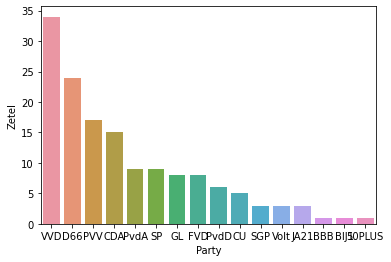

In [ ]:
sns.barplot(data=df_zetels, x='Party', y='Zetel')

In [ ]:
def visualise_term_mention(frame, words, normalisation=True,):
  df = frame.copy(deep=True)

  for w in words.keys():
    df[w] = 0
    for term in words[w]:
      df[w] += df.cleantext.str.count(term)

  df_word_counts = pd.DataFrame()

  for w in words:
    df_word_counts[w] = df.groupby("Bron")[w].agg("sum")

  df_word_counts = df_word_counts.reset_index()
  df_word_mentions = df_word_counts.melt("Bron")

  df_word_mentions = df_word_mentions.rename(columns={'variable':'Word','value':'Frequency'})

  if normalisation:
    df_norm = df_word_mentions.groupby('Bron').sum('Frequency').reset_index().rename(columns={'Frequency':'Total Freq'})
    df_word_mentions = df_word_mentions.merge(df_norm, on='Bron')
    df_word_mentions['Normalised_Freq'] = np.log(df_word_mentions['Frequency']/df_word_mentions['Total Freq'])

  mentions = df_word_mentions.pivot("Word", "Bron", "Normalised_Freq")
  mentions = mentions.reindex(words.keys())

  # bigger plot elements suitable for giving talks
  sns.set_context("talk")
  # set figure size
  plt.figure(figsize=(15,9))
  # Time series plot with Seaborn lineplot()
  sns.heatmap(mentions, cmap="YlGnBu")
  # axis labels
  plt.title("Newspaper Normalised Frequency")

In [ ]:
partijen_termen = {'VVD':['VVD', 'Volkspartij voor Vrijheid en Democratie',],
                   'D66':['D66', 'Democraten 66', "D'66"],
                   'PVV':['PVV', 'Partij voor de Vrijheid'],
                   'CDA':['CDA', 'Christen-Democratisch Appèl'],
                   'PvdA':['PvdA','PVDA', 'Partij van de Arbeid'],
                   'SP':['SP', 'Socialistische Partij'],
                   'GL':['GL', 'GroenLinks'],
                   'FVD': ['FVD', 'Forum Voor Democratie'],
                   'PvdD':['PvdD','Partij voor de Dieren'],
                   'CU':['CU', 'Christen Unie'],
                   'SGP':['SGP', 'Staatkundig Gereformeerde Partij'],
                   'Volt':['Volt'],
                   'JA21':['JA21'],
                   'BBB':['BBB', 'Boeren Burger Beweging'],
                   'BIJ1':['BIJ1'],
                   '50PLUS':['50PLUS'],
                   }
                   

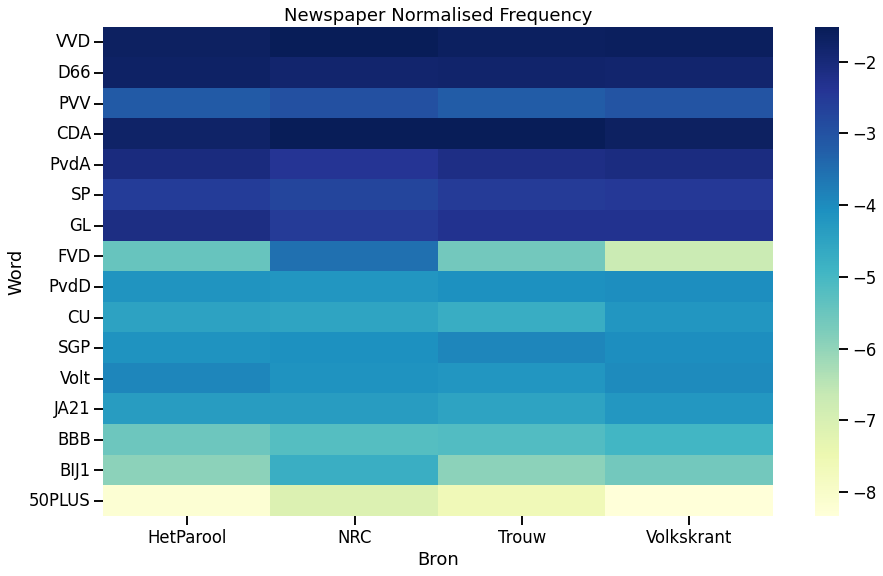

In [ ]:
# Rutte 3: VVD, D66, CDA, CU
visualise_term_mention(df, partijen_termen)

In [ ]:
politici_termen = {'Rutte':['Rutte'],
                   'Kaag':['Kaag'],
                   'Wilders':['Wilders'],
                   'Hoekstra':['Hoekstra'],
                   'Ploumen':['Ploumen'],
                   'Marijnissen':['Marijnissen'],
                   'Klaver':['Klaver'],
                   'Baudet': ['Baudet'],
                   'Ouwehand':['Ouwehand'],
                   'Segers':['Segers'],
                   'Staaij':['Staaij'],
                   'Dassen':['Dassen'],
                   'Eerdmans':['Eerdmans'],
                   'Plas':['Plas'],
                   'Simons':['Simons'],
                   'Den Haan':['Den Haan'],
                   }

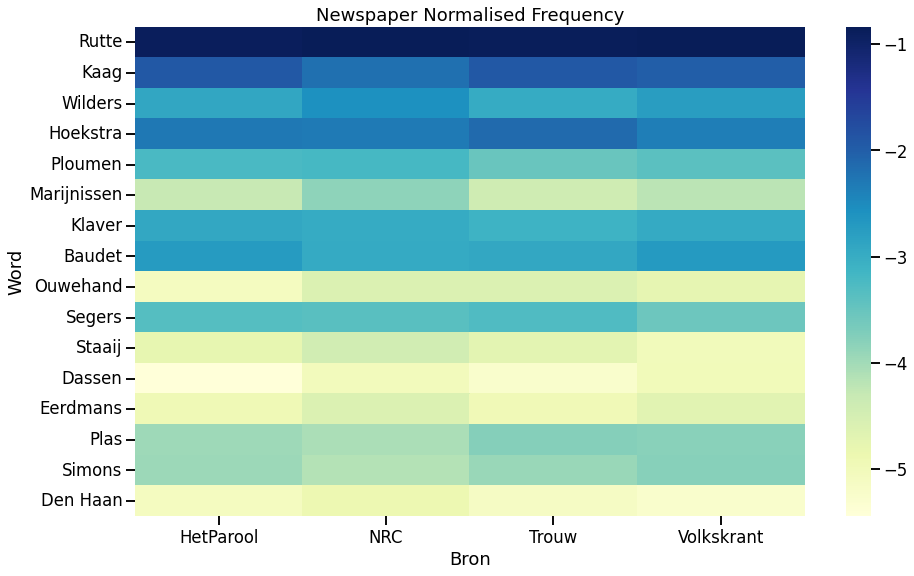

In [ ]:
visualise_term_mention(df, politici_termen)

# LDA

##LDA All

In [ ]:
# Remove the columns
articles = df.drop(columns=['url', 'publisherID', 'category',], axis=1)# Print out the first rows of papers
articles.head()

articles = articles[articles['cleantext'].notna()]

In [ ]:
# Remove punctuation
articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\\.!?]', '', x))
# Save D66
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('D66', 'dzeszes', x))
# Save BIJ1
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('BIJ1', 'bijeeen', x))
# Save 50PLUS
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('50PLUS', 'vijfplus', x))
# Save JA21
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('JA21', 'jatweeeen', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
#articles['cleantext_processed'].head()

stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo' ])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = articles.cleantext_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)

#print(data_words[:1][0][:30])

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1][0][:30])

# number of topics
num_topics = 25
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
doc_lda = lda_model[corpus]

def terms_topics_frame(terms):

  df = pd.DataFrame(data=None)

  for t in terms:
    df_t_topics = pd.DataFrame(lda_model.get_term_topics(t, minimum_probability=0.000000001))
    df_t_topics = df_t_topics.drop(columns=0)
    df_t_topics = df_t_topics.rename(columns={1:t})
    df = pd.concat([df, df_t_topics], axis=1)
  
  return df

df_tt = terms_topics_frame(['pvv', 'groenlinks', 'pvda', 'sp',
                            'dzeszes', 'vvd', 'sgp',
                            'bbb', 'volt', 'cu', 'cda',
                            'fvd', 'bijeeen', 'vijfplus', 'pvdd',
                            'jatweeeen']
)
df_tt['topic'] = df_tt.index

sns.set_theme(style="whitegrid")

# Plot the topic dist per term
df_tt.set_index('topic').plot(kind='bar', stacked=True)
sns.set(rc={'figure.figsize':(15,9)})

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
LDAvis = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis

KeyError: ignored

## LDA NRC

In [ ]:
# Remove the columns
articles = df_NRC.drop(columns=['url', 'publisherID', 'category',], axis=1)# Print out the first rows of papers
articles.head()

articles = articles[articles['cleantext'].notna()]

In [ ]:
# Remove punctuation
articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\\.!?]', '', x))
# Save D66
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('D66', 'dzeszes', x))
# Save BIJ1
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('BIJ1', 'bijeen', x))
# Save 50PLUS
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('50PLUS', 'vijfplus', x))
# Save JA21
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('JA21', 'jatweeeen', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
#articles['cleantext_processed'].head()

stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo' ])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = articles.cleantext_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)

#print(data_words[:1][0][:30])

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1][0][:30])

# number of topics
num_topics = 30
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
doc_lda = lda_model[corpus]

def terms_topics_frame(terms):

  df = pd.DataFrame(data=None)

  for t in terms:
    df_t_topics = pd.DataFrame(lda_model.get_term_topics(t, minimum_probability=0.000000001))
    df_t_topics = df_t_topics.drop(columns=0)
    df_t_topics = df_t_topics.rename(columns={1:t})
    df = pd.concat([df, df_t_topics], axis=1)
  
  return df

df_tt = terms_topics_frame(['pvv', 'groenlinks', 'pvda', 'sp',
                            'dzeszes', 'vvd', 'sgp',
                            'bbb', 'volt', 'cu', 'cda',
                            'fvd', 'bijeen', 'vijfplus', 'pvdd',
                            'jatweeeen']
)
df_tt['topic'] = df_tt.index

sns.set_theme(style="whitegrid")

# Plot the topic dist per term
df_tt.set_index('topic').plot(kind='bar', stacked=True)
sns.set(rc={'figure.figsize':(15,9)})

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
LDAvis = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis

# LDA Political

In [ ]:
# Remove the columns
articles = df.drop(columns=['url', 'publisherID', 'category',], axis=1)# Print out the first rows of papers

articles = articles[articles['cleantext'].notna()]

# Remove punctuation
articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\\.!?]', '', x))
# Save D66
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('D66', 'dzeszes', x))
# Save BIJ1
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('BIJ1', 'bijeeen', x))
# Save 50PLUS
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('50PLUS', 'vijfplus', x))
# Save JA21
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('JA21', 'jatweeeen', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
#articles['cleantext_processed'].head()

articles = articles[articles['cleantext_processed'].str.contains('pvv|groenlinks|pvda|sp|dzeszes|vvd|sgp|bbb|volt|cu|cda|fvd|bijeeen|vijfplus|pvdd|jatweeeen', regex=True)]

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.100773  0.033235       1        1  16.478770
14     0.148335  0.027348       2        1  16.173250
2      0.051110  0.090756       3        1  13.669215
10    -0.085317 -0.002942       4        1   9.021745
8     -0.121020  0.044618       5        1   6.236035
6     -0.023932  0.001567       6        1   5.359942
13     0.006839  0.010088       7        1   5.238412
12    -0.142838 -0.030023       8        1   4.446169
4     -0.126063 -0.003241       9        1   4.187551
1      0.080265 -0.133049      10        1   3.951653
11     0.083132  0.053104      11        1   3.685506
7     -0.039108  0.077715      12        1   3.417536
5      0.159115  0.069828      13        1   3.110318
0     -0.123161  0.037504      14        1   2.919784
9      0.031869 -0.276509      15        1   2.104113, topic_info=           Term           Freq          Total Category  logprob  loglift
1399       euro   32014.000000   32014.000000  Default  30.0000  30.0000
350       rutte   19970.000000   19970.000000  Default  29.0000  29.0000
334     kabinet   25439.000000   25439.000000  Default  28.0000  28.0000
125        jaar  132481.000000  132481.000000  Default  27.0000  27.0000
479     procent   45470.000000   45470.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
2564      derde    1798.769754    9022.866427  Topic15  -5.6909   2.2486
692      tweede    2108.246802   28649.252192  Topic15  -5.5321   1.2520
1117       keer    2154.627262   36945.334186  Topic15  -5.5104   1.0195
538   afgelopen    2048.587390   33273.129662  Topic15  -5.5608   1.0737
365         zei    1996.460597   39807.129817  Topic15  -5.5866   0.8686

[1460 rows x 6 columns], token_table=        Topic      Freq            Term
term                                   
45863       1  0.992574             aaf
61639       1  0.990512           aaide
9013        3  0.002599  aandeelhouders
9013        5  0.009531  aandeelhouders
9013        8  0.001733  aandeelhouders
...       ...       ...             ...
1347       13  0.013582          zullen
1347       14  0.026604          zullen
1347       15  0.008775          zullen
111510      1  0.989187        zwembond
111510      4  0.007382        zwembond

[8175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 15, 3, 11, 9, 7, 14, 13, 5, 2, 12, 8, 6, 1, 10])

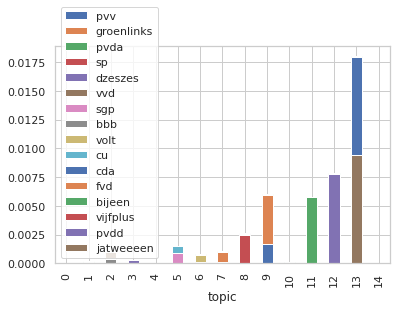

In [ ]:
stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo' ])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = articles.cleantext_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)

#print(data_words[:1][0][:30])

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1][0][:30])

# number of topics
num_topics = 15
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
doc_lda = lda_model[corpus]

def terms_topics_frame(terms):

  df = pd.DataFrame(data=None)

  for t in terms:
    df_t_topics = pd.DataFrame(lda_model.get_term_topics(t, minimum_probability=0.000000001))
    df_t_topics = df_t_topics.drop(columns=0)
    df_t_topics = df_t_topics.rename(columns={1:t})
    df = pd.concat([df, df_t_topics], axis=1)
  
  return df

df_tt = terms_topics_frame(['pvv', 'groenlinks', 'pvda', 'sp',
                            'dzeszes', 'vvd', 'sgp',
                            'bbb', 'volt', 'cu', 'cda',
                            'fvd', 'bijeen', 'vijfplus', 'pvdd',
                            'jatweeeen']
)
df_tt['topic'] = df_tt.index

sns.set_theme(style="whitegrid")

# Plot the topic dist per term
df_tt.set_index('topic').plot(kind='bar', stacked=True)
sns.set(rc={'figure.figsize':(15,9)})

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
LDAvis = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis

In [15]:
def lda_analysis(frame, path_lda, path_plot, topics=10):
  # Remove the columns
  articles = frame.drop(columns=['url', 'publisherID', 'category',], axis=1)# Print out the first rows of papers

  articles = articles[articles['cleantext'].notna()]

  # Remove punctuation
  articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\\.!?]', '', x))
  # Save D66
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('D66', 'dzeszes', x))
  # Save BIJ1
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('BIJ1', 'bijeeen', x))
  # Save 50PLUS
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('50PLUS', 'vijfplus', x))
  # Save JA21
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('JA21', 'jatweeeen', x))
  # Convert the titles to lowercase
  articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: x.lower())

  articles = articles[articles['cleantext_processed'].str.contains('pvv|groenlinks|pvda|sp|dzeszes|vvd|sgp|bbb|volt|cu|cda|fvd|bijeeen|vijfplus|pvdd|jatweeeen', regex=True)]

  stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo' ])

  def sent_to_words(sentences):
      for sentence in sentences:
          # deacc=True removes punctuations
          yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

  def remove_stopwords(texts):
      return [[word for word in simple_preprocess(str(doc)) 
              if word not in stop_words] for doc in texts]

  data = articles.cleantext_processed.values.tolist()
  data_words = list(sent_to_words(data))# remove stop words
  data_words = remove_stopwords(data_words)

  #print(data_words[:1][0][:30])

  # Create Dictionary
  id2word = corpora.Dictionary(data_words)

  # Create Corpus
  texts = data_words

  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]

  # View
  #print(corpus[:1][0][:30])

  # number of topics
  num_topics = topics
  # Build LDA model
  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics)
  doc_lda = lda_model[corpus]

  def terms_topics_frame(terms):

    df = pd.DataFrame(data=None)

    for t in terms:
      df_t_topics = pd.DataFrame(lda_model.get_term_topics(t, minimum_probability=0.000000001))
      df_t_topics = df_t_topics.drop(columns=0)
      df_t_topics = df_t_topics.rename(columns={1:t})
      df = pd.concat([df, df_t_topics], axis=1)
    
    return df

  df_tt = terms_topics_frame(['vvd','dzeszes','pvv','cda', 'pvda',  'sp','groenlinks','fvd','pvdd','cu',
                                'sgp','volt','jatweeeen','bbb', 'bijeeen', 'vijfplus']
  )
  df_tt['topic'] = df_tt.index

  sns.set_theme(style="whitegrid")

  # Plot the topic dist per term
  fig = df_tt.set_index('topic').plot(kind='bar', stacked=True)
  fig.figure.savefig(path_plot)

  # Visualize the topics
  pyLDAvis.enable_notebook()
  LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
  LDAvis = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
  pyLDAvis.save_html(LDAvis, path_lda)


In [16]:
lda_analysis(df,'gdrive/MyDrive/CS/Thesis/Testset_2021/LDA__.html','gdrive/MyDrive/CS/Thesis/Testset_2021/LDA__.png',topics=30)

KeyboardInterrupt: ignored